In [52]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [53]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [54]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split(',') for i in sents]
    return sents

In [55]:
data = read_text("final.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [56]:
deu_eng = deu_eng[:50000,:]

In [57]:
deu_eng

array([['strang', 'range'],
       ['brake', 'break'],
       ['brack', 'break'],
       ...,
       ["weeks'", "week's"],
       ['weks', "week's"],
       ["wig's", "week's"]], dtype='<U25')

In [58]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [59]:
deu_eng

array([['strang', 'range'],
       ['brake', 'break'],
       ['brack', 'break'],
       ...,
       ['weeks', 'weeks'],
       ['weks', 'weeks'],
       ['wigs', 'weeks']], dtype='<U25')

In [60]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['strang', 'range'],
       ['brake', 'break'],
       ['brack', 'break'],
       ...,
       ['weeks', 'weeks'],
       ['weks', 'weeks'],
       ['wigs', 'weeks']], dtype='<U25')

In [61]:
deu_eng

array([['strang', 'range'],
       ['brake', 'break'],
       ['brack', 'break'],
       ...,
       ['weeks', 'weeks'],
       ['weks', 'weeks'],
       ['wigs', 'weeks']], dtype='<U25')

In [62]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [63]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

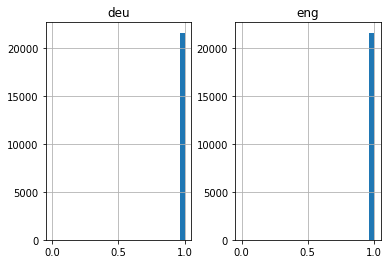

In [64]:
length_df.hist(bins = 30)
plt.show()

***Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.***

In [65]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

***It's time to encode the sentences. We will encode incorrect words as the input sequences and correct words as the target sequences. It will be done for both train and test datasets.***

In [66]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 19639


In [67]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 5149


In [68]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [69]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [70]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [71]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

***Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.***

In [72]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [73]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [74]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 13804 samples, validate on 3452 samples
Epoch 1/10
13804/13804 [==============================] - 171s 12ms/step - loss: 3.2736 - val_loss: 1.4580

Epoch 00001: val_loss improved from inf to 1.45801, saving model to model.h1.24_jan_19
Epoch 2/10
13804/13804 [==============================] - 172s 12ms/step - loss: 1.2718 - val_loss: 1.3802

Epoch 00002: val_loss improved from 1.45801 to 1.38020, saving model to model.h1.24_jan_19
Epoch 3/10
13804/13804 [==============================] - 170s 12ms/step - loss: 1.2185 - val_loss: 1.4254

Epoch 00003: val_loss did not improve from 1.38020
Epoch 4/10
13804/13804 [==============================] - 176s 13ms/step - loss: 1.2074 - val_loss: 1.4384

Epoch 00004: val_loss did not improve from 1.38020
Epoch 5/10
13804/13804 [==============================] - 178s 13ms/step - loss: 1.2012 - val_loss: 1.4510

Epoch 00005: val_loss did not improve from 1.38020
Epoch 6/10
13804/13804 [==============================] - 174s 13ms/step - loss:

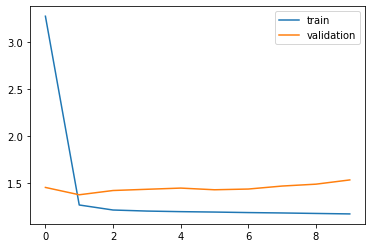

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [76]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [77]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [78]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [85]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [86]:
pd.set_option('display.max_colwidth', 200)

In [87]:
pred_df.head(15)

,actual,predicted
0,biscuit,
1,enemy,
2,answering,
3,take,
4,integrity,
5,unanimous,
6,attack,
7,acknowledgment,
8,ceilings,
9,tea,


In [88]:
pred_df.tail(15)

,actual,predicted
4300,bungalow,
4301,evident,
4302,permanently,
4303,ordinarily,
4304,unfortunately,
4305,sympathetic,
4306,economics,
4307,anxiety,
4308,basketball,
4309,encyclopedia,


In [89]:
pred_df.tail(15)

,actual,predicted
4300,bungalow,
4301,evident,
4302,permanently,
4303,ordinarily,
4304,unfortunately,
4305,sympathetic,
4306,economics,
4307,anxiety,
4308,basketball,
4309,encyclopedia,


In [90]:
pred_df.sample(15)

,actual,predicted
3140,civilized,
3824,prejudice,
2835,moisture,
1663,guarantee,
587,attaching,
2992,miscellaneous,
2547,attorneys,
3905,dust,
4049,alumni,
3446,courtesies,
